In [2]:
import pandas as pd
import sklearn.metrics as skm
import numpy as np

In [10]:
TAGGED_SAMPLED_TOKENS_CSV_NAME = 'english_samples_v4_annotations.csv'#'sampled_tagged.csv' # 'english_samples_v4_annotations.csv'
TAGGER_TO_CHILDES_POS_MAPPING_CSV_NAME = "spacy_childes_pos_mapping_full - spacy_childes_pos_mapping_full.csv"
CHILDES_POS_REMAPPING_CSV_NAME = "childes_pos_remapping_full - childes_simplified_pos_full.csv"
MODEL_NAME = 'spacy'
CONVERTED_SAMPLED_TOKENS_CSV_NAME = 'sampled_remapped.csv'

In [11]:
samples = pd.read_csv(TAGGED_SAMPLED_TOKENS_CSV_NAME, keep_default_na=False, index_col=0)
samples

,token_id,gloss,utterance_id,utterance_gloss,part_of_speech,log_frequency_bin,speaker_role,spacy_part_of_speech,spacy_morphology,childes_remapped_part_of_speech,spacy_pos_converted,agree,correct_pos,ill-formed,comment
0,61545509,ought,16869004,the shortcut led right to where Harold thought...,mod,1,Mother,AUX,VerbType=Mod,mod,mod,True,mod,,
1,62585566,onto,17115248,I'm not allowing you to reach things onto the ...,prep,2,Mother,ADP,,prep,prep,True,prep,,
2,62696473,dare,17144700,I dare not go,mod,1,Mother,AUX,Tense=Pres|VerbForm=Fin,mod,mod,True,mod,,
3,62150711,behind,17024078,yyy knee behind the letters,prep,2,Target_Child,ADP,,prep,prep,True,prep,,
4,62040337,greenish,16983158,is that kind of a greenish blue,adj,0,Mother,ADJ,Degree=Pos,adj,adj,True,adj,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198,61329354,thirteen,16820893,before thirteen,det:num,1,Media,NUM,NumType=Card,num,num,True,num,,
1199,61330648,eighteen,16827005,eighteen,det:num,1,Mother,NUM,NumType=Card,num,num,True,num,,
1200,61329154,thirteen,16819772,thirteen good job,det:num,1,Media,NUM,NumType=Card,num,num,True,num,,
1201,62751605,seven,17160155,six little fingers icy and shaking seven littl...,det:num,2,Mother,NUM,NumType=Card,num,num,True,num,,


In [5]:
tagger_childes_mapping = pd.read_csv(TAGGER_TO_CHILDES_POS_MAPPING_CSV_NAME, keep_default_na=False)
childes_remapping = pd.read_csv(CHILDES_POS_REMAPPING_CSV_NAME, keep_default_na=False)
# tagger_childes_mapping.rename(columns={'spacy_part_of_speech':'tagger_part_of_speech', 'spacy_morphology':'tagger_morphology', 'spacy_pos_converted':'tagger_pos_converted'}, inplace=True)

def tagger_to_childes_pos(tagger_pos, tagger_morph):
    '''
    given a tagger's part-of-speech and morphology, return a converted part-of-speech
    '''
    matches = tagger_childes_mapping[tagger_childes_mapping[MODEL_NAME + '_part_of_speech'] == tagger_pos]
    matches = matches[matches[MODEL_NAME + '_morphology'] == tagger_morph]
    if len(matches) < 1:
        print("no match for", tagger_pos, tagger_morph)
        return ""
    # return matches.iloc[0]['childes_remapped_part_of_speech']
    return matches.iloc[0][MODEL_NAME + '_pos_converted']

def childes_remapped_pos(childes_pos, tagger_pos):
    '''
    given a childes part-of-speech, return its remapped form
    necessary because some tagger categories map to multiple more specific childes categories, which are all correct
    '''
    # first check if it's an interjection -- there is no good childes tag, so consider them all correct
    if tagger_pos == "INTJ" or tagger_pos == 'intj' or tagger_pos == 'UH':
        new_pos = "intj"
        return new_pos
    
    # if not, then use the mapping in childes_remapping
    # matches = childes_remapping[childes_remapping['childes_original_pos'] == childes_pos]
    matches = childes_remapping[childes_remapping['childes_simplified_pos'] == childes_pos]
    new_pos = matches.iloc[0]['childes_remapped_pos']
    return new_pos

In [12]:
new_samples = samples.copy()
new_samples["childes_remapped_part_of_speech"] = new_samples.apply(lambda row: childes_remapped_pos(row["part_of_speech"], row[MODEL_NAME + "_part_of_speech"]), axis=1)
new_samples[MODEL_NAME + "_pos_converted"] = new_samples.apply(lambda row: tagger_to_childes_pos(row[MODEL_NAME + "_part_of_speech"], row[MODEL_NAME + "_morphology"]), axis=1)
new_samples['agree'] = new_samples['childes_remapped_part_of_speech'] == new_samples[MODEL_NAME + "_pos_converted"]
new_samples

,token_id,gloss,utterance_id,utterance_gloss,part_of_speech,log_frequency_bin,speaker_role,spacy_part_of_speech,spacy_morphology,childes_remapped_part_of_speech,spacy_pos_converted,agree,correct_pos,ill-formed,comment
0,61545509,ought,16869004,the shortcut led right to where Harold thought...,mod,1,Mother,AUX,VerbType=Mod,mod,mod,True,mod,,
1,62585566,onto,17115248,I'm not allowing you to reach things onto the ...,prep,2,Mother,ADP,,prep,prep,True,prep,,
2,62696473,dare,17144700,I dare not go,mod,1,Mother,AUX,Tense=Pres|VerbForm=Fin,mod,mod,True,mod,,
3,62150711,behind,17024078,yyy knee behind the letters,prep,2,Target_Child,ADP,,prep,prep,True,prep,,
4,62040337,greenish,16983158,is that kind of a greenish blue,adj,0,Mother,ADJ,Degree=Pos,adj,adj,True,adj,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198,61329354,thirteen,16820893,before thirteen,det:num,1,Media,NUM,NumType=Card,num,num,True,num,,
1199,61330648,eighteen,16827005,eighteen,det:num,1,Mother,NUM,NumType=Card,num,num,True,num,,
1200,61329154,thirteen,16819772,thirteen good job,det:num,1,Media,NUM,NumType=Card,num,num,True,num,,
1201,62751605,seven,17160155,six little fingers icy and shaking seven littl...,det:num,2,Mother,NUM,NumType=Card,num,num,True,num,,


In [16]:
def fill_gold(x):
    if x['correct_pos'] != '':
        return x['correct_pos']
    if x['childes_remapped_part_of_speech'] == x[MODEL_NAME + '_pos_converted']:
        return x['childes_remapped_part_of_speech']
    return '' # we don't know the gold label

def childes_match_gold(x):
    childes_label, tagger_label, gold = x['childes_remapped_part_of_speech'], x[MODEL_NAME + '_pos_converted'], x['temporary_gold']
    if gold == "":
        return childes_label == tagger_label
    return childes_label == gold

def tagger_match_gold(x):
    childes_label, tagger_label, gold = x['childes_remapped_part_of_speech'], x[MODEL_NAME + '_pos_converted'], x['temporary_gold']
    if gold == "":
        return childes_label == tagger_label
    return tagger_label == gold

def score(df, use_childes=True):
    if use_childes:
        col_name = "childes_remapped_part_of_speech"
    else:
        col_name = MODEL_NAME + '_pos_converted'
        
    labels = df[col_name].drop_duplicates()
    p = skm.precision_score(new_samples["temporary_gold"], new_samples[col_name], labels=labels, average='micro')
    r = skm.recall_score(new_samples["temporary_gold"], new_samples[col_name], labels=labels, average='micro')
    f1 = skm.f1_score(new_samples["temporary_gold"], new_samples[col_name], labels=labels, average='micro')
    return {'precision': p, 'recall': r, 'f1': f1}

def confusion_matrix(df, use_childes=True):
    if use_childes:
        col_name = "childes_remapped_part_of_speech"
    else:
        col_name = MODEL_NAME + '_pos_converted'
        
    labels = df[col_name].drop_duplicates()
    confusion = skm.confusion_matrix(new_samples["temporary_gold"], new_samples[col_name], labels=labels)
    return {'labels': labels, 'matrix': confusion}



In [17]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

overall:
{'precision': 0.8146300914380715, 'recall': 0.8949771689497716, 'f1': 0.8529155787641427}
{'precision': 0.8370739817123857, 'recall': 0.919634703196347, 'f1': 0.876414273281114}


/home/szhi/childes-db/childes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/home/szhi/childes-db/childes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/szhi/childes-db/childes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


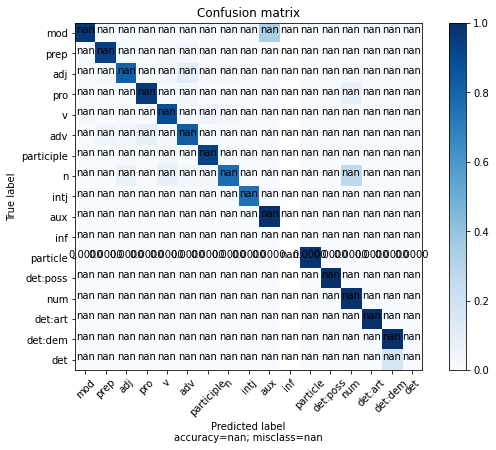

/home/szhi/childes-db/childes_py3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


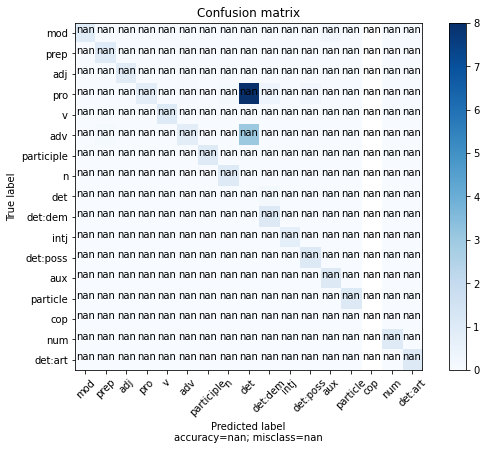

"\nutt_len_samples = new_samples.copy()\nutt_len_samples['utterance_length'] = utt_len_samples.apply(lambda x: len(x['utterance_gloss']), axis=1)\ngb = utt_len_samples.groupby(by='utterance_length')\nfor name, group in gb:\n    print(name)\n    print(score(group))\n"

In [19]:
new_samples['temporary_gold'] = new_samples.apply(lambda x: fill_gold(x), axis=1)

def print_scores_by_group(by):
    groupby = new_samples.groupby(by=by)
    for name, group in groupby:
        print(name)
        # print(group)
        print(score(group))

print("overall:")
print(score(new_samples))
print(score(new_samples, use_childes=False))

matrix = confusion_matrix(new_samples)
labels = matrix['labels']
cm = matrix['matrix']
cmn = cm / cm.astype(np.float).sum(axis=1)
plot_confusion_matrix(cmn, labels, title='Confusion matrix')

matrix = confusion_matrix(new_samples, use_childes=False)
labels = matrix['labels']
cm = matrix['matrix']
cmn = cm / cm.astype(np.float).sum(axis=1)
plot_confusion_matrix(cmn, labels, title='Confusion matrix')

#print_scores_by_group('temporary_gold')
# TODO: need to delete space after mod in temporary_gold labels
# aux precision is low
# surprisingly noun scores are not that high

# print_scores_by_group('speaker_role')
# no particular speaker has especially high or low scores (except Visitor but only bc so few samples)

# print_scores_by_group('log_frequency_bin')
# no frequency bin has especially high or low scores

# print_scores_by_group(['temporary_gold', 'log_frequency_bin'])
# still no patterns

# judge by utterance length
'''
utt_len_samples = new_samples.copy()
utt_len_samples['utterance_length'] = utt_len_samples.apply(lambda x: len(x['utterance_gloss']), axis=1)
gb = utt_len_samples.groupby(by='utterance_length')
for name, group in gb:
    print(name)
    print(score(group))
'''
# slight improvement towards longer utterances



In [95]:
new_samples.to_csv(CONVERTED_SAMPLED_TOKENS_CSV_NAME)